In [156]:
#This assignment will use MNIST data to build an active learning model
#We will use the entire MNIST data set, with an 80/20 split for training and testing


#references
1#ttps://en.wikipedia.org/wiki/Active_learning_(machine_learning)


1

In [157]:
#1. import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

from graphviz import Digraph

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from sklearn.datasets import fetch_openml

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor


from IPython.display import Image

from datetime import datetime

In [158]:
#homework framework
#check data path
data_path = '/../data/mnist/'


mnist_data_file = 'mnist_full_784.npy'
mnist_labels_file = 'mnist_full_labels_784.npy'


if os.path.exists(os.getcwd() + data_path + mnist_data_file):
    X = np.load(os.getcwd() + data_path + mnist_data_file, allow_pickle=True)

if os.path.exists(os.getcwd() + data_path + mnist_labels_file):
    y = np.load(os.getcwd() + data_path + mnist_labels_file, allow_pickle=True)

#define report location
report_folder = '/report/'
report_images = report_folder + 'resources/images/'

#check if the folder exists
if not os.path.exists(report_image_path := os.getcwd() + report_images):
    os.makedirs(os.getcwd() + report_images)
    
if not os.path.exists(os.getcwd() + report_images):
    print(f'{report_image_path} could not be created')
    exit()

print(f'Using {report_image_path} for report images.')


Using h:\dev\git\csc730\assignment 8/report/resources/images/ for report images.


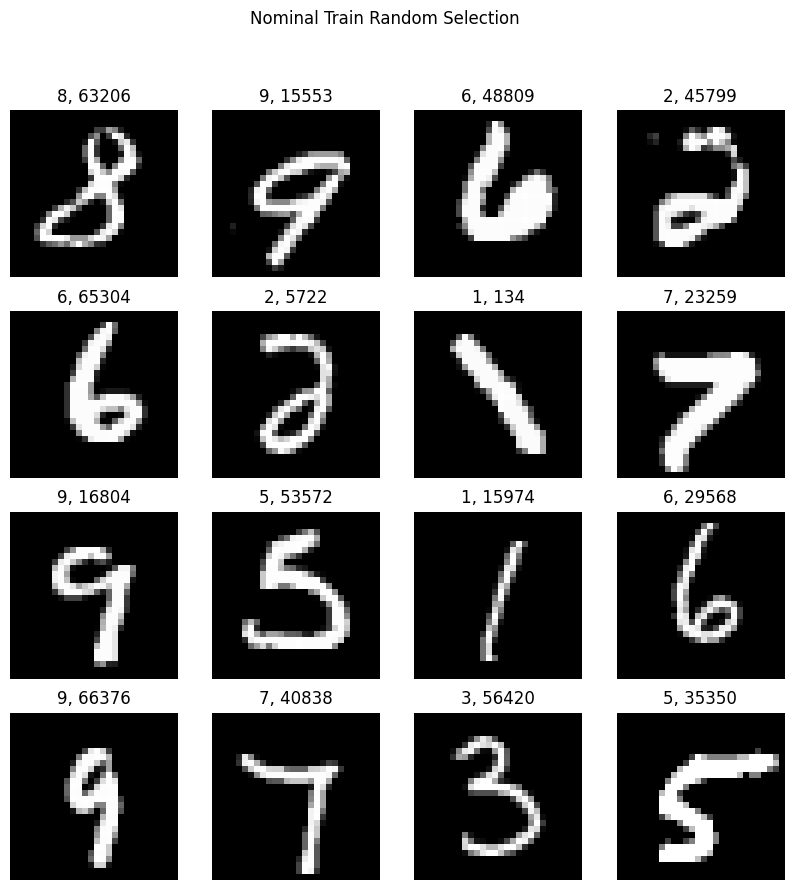

In [159]:
#generate example data figures
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = np.random.randint(0, X.shape[0])
        ax[i, j].imshow(X[index].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f'{y[index]}, {index}')
        ax[i, j].axis('off')
plt.suptitle('Nominal Train Random Selection')        
plt.savefig(report_image_path + '_nominal_train_random_selection.png')
plt.show()

The active learning algorithm has the following psuedocode  

Input: Dl, Du, h  
Output: h  

Psuedocode from paper
1) Train h using Dl
2) While stopping conditions not met Do  
    1) For each instance Xi in Du  
        1) ui = u(Xi, h)  
    1) End for  
    1) i* = argmax(ui, i)
    2) x* = xi*
    3) y* = query(x*)
    4) Dl = Dl union (x*, y*)
    5) Du = Du subtract x*
    6) Update h based on new Dl
9) End while

My interpretation
utility_value(x) returns the utility value of point x

1) confusion_matrices = []
1) stopping_condition = (accuracy(X_test) >= threshold) or (max_iterations >= iteration_threshold)
1) Dl = empty list
2) Dl.append(choose_first_point(X,y))
2) model = active_learn.fit(Dl)
2) confusion_matrices.append(model)
3) stopping_condition = (accuracy(X_test) >= threshold) or (max_iterations >= iteration_threshold)
3) while not stopping_condition
    3) utility_scores = [utility_value(x) for x in Du]
    3) best_utility_index = argmax(utility_scores)
    4) Dl.append(X_train[best_utility_index], y_train[best_utility_index])
    4) Du.remove(X_train[best_utility_index], y_train[best_utility_index])
    5) model = active_learn.fit(Dl)
    5) confusion_matrices.append(model)
    6) stopping_condition = (accuracy(X_test) >= threshold) or (max_iterations >= iteration_threshold)    
4) Generate graphs

@article{tharwat2023survey,
  title={A survey on active learning: state-of-the-art, practical challenges and research directions},
  author={Tharwat, Alaa and Schenck, Wolfram},
  journal={Mathematics},
  volume={11},
  number={4},
  pages={820},
  year={2023},
  publisher={MDPI}
}

<https://doi.org/10.3390/math11040820>

In [160]:

class active_model_learning():
    def __init__(self, model, accuracy_threshold=0.95, max_iterations=1000, verbose=True, random_state=42, strategy_function=None,  test_split=0.2):
        self.model = model
        self.strategy_function = strategy_function
        
        self._test_split = test_split
        self._random_state = random_state                  
        
        self.confusion_matrices = []
        self.calculable_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": [], "roc_auc": [], "pr_auc": []}
        self.accuracy_threshold = accuracy_threshold
        self.accuracy_threshold_reached = False
        self.max_iterations = max_iterations
        self.current_iteration = 0
        self.verbose = verbose
        self.X_test = None
        self.y_test = None
        self._next_index=0
        
        
        
        
    def _select_point_from_pool(self):
        #place X[index] and y[index] into Dl_X and Dl_y
        if self.Dl_X.shape[0] == 0:
            self.Dl_X = self.Du_X[self._next_index].reshape(1, -1)
            self.Dl_y = np.array([self.Du_y[self._next_index]])
        else:        
            self.Dl_X = np.append(self.Dl_X,self.Du_X[self._next_index].reshape(1, -1), axis=0)
            self.Dl_y = np.append(self.Dl_y, [self.Du_y[self._next_index]], axis=0)
        
        #remove X[index] and y[index] from Du_X and Du_y
        self.Du_X = np.delete(self.Du_X, self._next_index, axis=0)
        self.Du_y = np.delete(self.Du_y, self._next_index, axis=0)
    
    def _train_model(self):
        if self.verbose:
            print(f"Training model on {len(self.Dl_X)} points. Iteration {self.current_iteration} at {datetime.now()}")
            start_time = datetime.now()
            
        try:
            self.model.fit(self.Dl_X, self.Dl_y)
        except ValueError as e:
            print(f"Error: {e}")
            print(f"Model: {self.model}")
            print(f"X: {self.Dl_X}")
            print(f"y: {self.Dl_y}")
            #add data point to the model and continue
            self._next_index = np.random.randint(0, self.Du_X.shape[0])
            self._select_point_from_pool()
        
        if self.verbose:
            print(f"Training time: {datetime.now() - start_time}")
        
    def test_model(self, X, y):
        y_pred = self.model.predict(X)
        self.confusion_matrices.append(confusion_matrix(y, y_pred))
        
        if self.verbose:
            print(f"Confusion matrix for iteration {self.current_iteration}: {self.confusion_matrices[-1]}")
            
    def _test_model(self):            
        self.test_model(self.X_test, self.y_test)        
        
    def evaluate_model(self, X, y):
        self.test_model(X, y)
        
        fp = (self.confusion_matrices[-1].sum(axis=0) - np.diag(self.confusion_matrices[-1]))
        fn = (self.confusion_matrices[-1].sum(axis=1) - np.diag(self.confusion_matrices[-1]))
        tp = np.diag(self.confusion_matrices[-1])
        tn = self.confusion_matrices[-1].sum() - (fn + tp + fn)
        
        accuracy = (tp + tn) / (tp + tn + fn + fp)
        self.calculable_metrics["accuracy"].append(accuracy)
        self.calculable_metrics["precision"].append(tp / (tp + fp))
        self.calculable_metrics["recall"].append(tp / (tp + fn))
        self.calculable_metrics["f1"].append(2 * (self.calculable_metrics["precision"][-1] * self.calculable_metrics["recall"][-1]) / (self.calculable_metrics["precision"][-1] + self.calculable_metrics["recall"][-1]))
        #self.calculable_metrics["roc_auc"].append(roc_auc_score(y, self.model.predict_proba(X)))
        #self.calculable_metrics["pr_auc"].append(auc(*precision_recall_curve(y, self.model.predict_proba(X))[:2]))        
        
        if self.verbose:
            print(f"Accuracy for iteration {self.current_iteration}: {accuracy}")
            
        if accuracy.min() >= self.accuracy_threshold:
            self.accuracy_threshold_reached = True
            if self.verbose:
                print(f"Accuracy threshold reached at iteration {self.current_iteration}")
        return accuracy

    def _evaluate_model(self):
        return self.evaluate_model(self.X_test, self.y_test)
        
    def utility_function(self, X):
        #return the point with the highest uncertainty
        if self.strategy_function is None:
            #check if the model has a predict_proba method
            if not hasattr(self.model, "predict_proba"):
                array = np.zeros(X.shape[0])
                array[np.random.randint(0, X.shape[0])] = 1
                return array                
                
            return self.model.predict_proba(X)
        else:
            return self.strategy_function(self, X)
    
    def utility_function_index(self, X):
        #return the point with the highest uncertainty
        return np.argmax(self.utility_function(X))
    
    def _utility_function_index(self):
        #return the point with the highest uncertainty
        self._next_index = np.argmax(self.utility_function(self.Du_X))
        
        if self._next_index >= self.Du_X.shape[0]:
            if self.verbose:
                print(f"Index out of range: {self._next_index}")
            self._next_index = np.random.randint(0, self.Du_X.shape[0])
            
        if self.verbose:
            print(f"Selected index {self._next_index} for iteration {self.current_iteration}")
        return self._next_index
    
    def _run_next(self):
        self.current_iteration += 1
        if self.accuracy_threshold_reached:
            return False
        if self.current_iteration >= self.max_iterations:
            return False
        return True
    
    def report(self):
        print(f"Final accuracy: {self.evaluate_model(self.X_test, self.y_test)}")
        print(f"Final confusion matrix: {self.confusion_matrices[-1]}")
        print(f"Final iteration: {self.current_iteration}")
        print(f"Final accuracy threshold reached: {self.accuracy_threshold_reached}")
    
    def generate_graphs(self):
        #add 5 confusion matrices images into the main plot as insets
        figs = []
        axes = []
        
        fig, ax = plt.subplots(1, 5, figsize=(20, 4))
        figs.append(fig)
        axes.append(ax)
        indices_to_plot = np.linspace(1, len(self.confusion_matrices), 5).astype(int)
                
        for i in range(5):
            ax[i].imshow(self.confusion_matrices[indices_to_plot[i]-1], cmap='binary')
            ax[i].set_title(f"Confusion matrix {indices_to_plot[i]}")
        fig.suptitle(f"Confusion matrices for {self.model.__class__.__name__}", fontsize=24)
        
        fig.show()      
        
        fig, ax = plt.subplots(figsize=(20, 20))
        figs.append(fig)
        axes.append(ax)
        ax.plot(self.calculable_metrics["accuracy"], label=np.unique(self.Du_y))
        ax.set_title(f"Accuracy over iterations {self.model.__class__.__name__}\nStrategy: {self.strategy_function.__name__} ", fontsize=24)
        ax.set_xlabel("Iteration", fontsize=18)
        ax.set_ylabel("Accuracy", fontsize=18)  
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.legend(prop={'size': 14})                  
        plt.show()
        
        fig, ax = plt.subplots(figsize=(20, 20))
        figs.append(fig)
        axes.append(ax)
        ax.plot(np.average(np.array(self.calculable_metrics["accuracy"]),axis=1), label="Average accuracy")
        ax.plot(np.amin(np.array(self.calculable_metrics["accuracy"]),axis=1), label="Minimum accuracy")
        ax.plot(np.amax(np.array(self.calculable_metrics["accuracy"]),axis=1), label="Maximum accuracy")
        ax.set_title(f"Average accuracy over iterations {self.model.__class__.__name__}\nStrategy: {self.strategy_function.__name__}", fontsize=24)
        ax.set_xlabel("Iteration", fontsize=18)
        ax.set_ylabel("Accuracy", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_ylim([0, 1])
        ax.set_xlim([0, self.current_iteration])    
        
        
        ax.legend(prop={'size': 14})
        
        #add confusion matrix images into the main plot as insets
        #MARK: add confusion matrix images into the main plot as insets
        for i in range(5):
            #ax_inset = fig.add_axes([indices_to_plot[i]-1, indices_to_plot[i]+self.current_iteration/5, 0.4, 0.4 ])
            
            height_new_plot = 0.125
            width_new_plot = 0.125
            y_range = fig.axes[0].get_ylim()[1] - fig.axes[0].get_ylim()[0]            
            x_range = fig.axes[0].get_xlim()[1] - fig.axes[0].get_xlim()[0]
            
            y_point = np.average(np.array(self.calculable_metrics["accuracy"]),axis=1)[indices_to_plot[i]-1]
            x_point = indices_to_plot[i] - 1
                                    
            left_position =  0.02+(i/6.5)
            bottom_position = 0.25#(y_relative - height_new_plot) if y_relative < 0.5 else (y_relative + height_new_plot)
                        
            ax_inset = fig.add_axes([left_position+width_new_plot, bottom_position,width_new_plot,height_new_plot ],alpha=0.5)
            
            ax_inset.imshow(self.confusion_matrices[indices_to_plot[i]-1], cmap='binary')
            ax_inset.set_xticks(np.arange(0.5, 10.5, 1))
            ax_inset.set_yticks(np.arange(0.5, 10.5, 1))
            ax_inset.set_xticklabels(np.arange(0, 10, 1))
            ax_inset.set_yticklabels(np.arange(0, 10, 1))
            ax_inset.grid(True)
            #now draw a line to the data point
            
            #ax.plot([indices_to_plot[i]-1, indices_to_plot[i]-1], [bottom_position, np.average(np.array(self.calculable_metrics["accuracy"]),axis=1)[indices_to_plot[i]-1]], color='black', linestyle='--')
            
            ax_inset.set_title(f"Confusion matrix {indices_to_plot[i]}", fontsize=18)           
            #ax_inset.set_title(f"{left_position:0.2f}, {bottom_position:0.2f}, {width_new_plot:0.2f}, {height_new_plot:0.2f}")
        plt.show()
        
        return figs, axes
    
    
    def fit(self, X, y):
         
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self._test_split, random_state=self._random_state)           
                        
        self.Du_X = np.array(self.X_train); self.Du_y = np.array(self.y_train); self.Du = (self.Du_X, self.Du_y)
        #match the shape of the data, except for the index column which will be 1
        #shape = list(X.shape); shape[0] = 1; shape = tuple(shape)
        self.Dl_X = np.array([]); self.Dl_y = np.array([]); self.Dl = (self.Dl_X, self.Dl_y) 
        
        #select a point from the pool at random
        self._next_index = np.random.randint(0, self.Du_X.shape[0])
        self._select_point_from_pool()                     
        
        self._next_index = np.random.randint(0, self.Du_X.shape[0])
        self._select_point_from_pool()
        self._train_model()               
        
        while self._run_next():   
            self._utility_function_index()
            self._select_point_from_pool()
            self._train_model()
            self._evaluate_model()
                        
        if self.verbose:
            print(f"Model training complete at iteration {self.current_iteration}")
            
        return self.accuracy_threshold_reached

def default_strategy(obj, X):
    return obj.model.predict_proba(X)

def random_strategy(obj, X):
    array = np.zeros(X.shape[0])
    array[np.random.randint(0, X.shape[0])] = 1
    return array    

def uncertainty_strategy(obj, X):
    return 1 - obj.model.predict_proba(X).max(axis=1)

def margin_strategy(obj, X):
    return np.abs(obj.model.predict_proba(X).max(axis=1) - obj.model.predict_proba(X).min(axis=1))

def entropy_strategy(obj, X):
    return -np.sum(obj.model.predict_proba(X) * np.log(obj.model.predict_proba(X)), axis=1) 

def query_by_comittee_strategy(obj, X):
    #get the predictions from the model
    predictions = obj.model.predict(X)
    #get the unique predictions
    unique_predictions = np.unique(predictions)
    #get the number of unique predictions
    number_of_unique_predictions = unique_predictions.shape[0]
    #create an array to store the votes
    votes = np.zeros((X.shape[0], number_of_unique_predictions))
    #for each unique prediction
    for i, unique_prediction in enumerate(unique_predictions):
        #get the votes for the unique prediction
        votes[:, i] = predictions == unique_prediction
    #return the sum of the votes
    return votes.sum(axis=1)





In [161]:

accuracy_threshold = 0.95
max_iterations = 1000
verbose = False
strategies = [default_strategy, random_strategy, uncertainty_strategy, margin_strategy, entropy_strategy, query_by_comittee_strategy]
#strategies = [default_strategy]
models = [ SVC(probability=True, random_state=42), RandomForestClassifier(n_estimators=100, random_state=42)]
#models = [ SVC(probability=True, random_state=42)]
active_learner = []

for model in models:
    for strategy in strategies:
        active_learner.append(active_model_learning(model, accuracy_threshold=accuracy_threshold, max_iterations=max_iterations, verbose=verbose, strategy_function=strategy, test_split=0.2, random_state=42))
        active_learner[-1].fit(X, y)
        active_learner[-1].report()
        figs, axes = active_learner[-1].generate_graphs()
        figs[0].suptitle(f"Confusion matrices for {model.__class__.__name__}\\n{'default strategy' if strategy==None else strategy.__name__} strategy")
        figs[0].savefig(report_image_path +f"confusion_matrices_{model.__class__.__name__}_{'default strategy' if strategy==None else strategy.__name__}.png")
        axes[1].set_title(f"Accuracy over iterations\nactive learning with {model.__class__.__name__} and {'default strategy' if strategy==None else strategy.__name__} strategy")
        figs[1].savefig(report_image_path +f"active_learning_{model.__class__.__name__}_{'default strategy' if strategy==None else strategy.__name__}.png")
        figs[2].savefig(report_image_path +f"active_learning_{model.__class__.__name__}_{'default strategy' if strategy==None else strategy.__name__}_average.png")
        np.savez(f"active_learning_{model.__class__.__name__}_{'default strategy' if strategy==None else strategy.__name__}.npz", confusion_matrices=active_learner[-1].confusion_matrices, calculable_metrics=active_learner[-1].calculable_metrics, allow_pickle=True)

"""active_learner = active_model_learning(rf_model, X, y, accuracy_threshold=accuracy_threshold, max_iterations=max_iterations, verbose=verbose)
active_learner.run()
active_learner.report()
figs, axes = active_learner.generate_graphs()
axes[0].set_title(f"Confusion matrices for random forest")
figs[0].savefig("confusion_matrices_rf.png")

axes[1].set_title(f"Accuracy over iterations\nactive learning with random forest and default strategy")
figs[1].savefig("active_learning_rf_default.png")
np.savez("active_learning_rf_default.npz", confusion_matrices=active_learner.confusion_matrices, calculable_metrics=active_learner.calculable_metrics, allow_pickle=True)


"""


C:\Users\krisr\AppData\Local\Temp\ipykernel_15632\35855506.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_15632\35855506.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_15632\35855506.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_15632\35855506.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_15632\35855506.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_15632\35855506.py:75: RuntimeWarning: invalid value enco